In [1]:
import numpy as np
import pandas as pd
import os
import shutil

In [2]:
crossroad_df=pd.read_csv("annotations.csv",names=["img_name","x_min","y_min","x_max","y_max","label"])

In [3]:
crossroad_df["img_name"]=crossroad_df["img_name"].str.replace("C:/Users/35841/images/xml_citycenter_focussed/","").str.replace(".png","")
crossroad_df["count"]=crossroad_df["img_name"].str.extract((r'(\d+)'))
crossroad_df["count"]=crossroad_df["count"].astype(int)
crossroad_df=crossroad_df.sort_values(by=["count"])
crossroad_df.head(5)

,img_name,x_min,y_min,x_max,y_max,label,count
0,center_0,1,1,496,497,Unknown,0
1,center_1,2,1,497,500,Unknown,1
16,center_2,344,390,491,479,crossroad,2
15,center_2,333,291,484,365,crossroad,2
29,center_3,1,1,499,500,Unknown,3


In [4]:
numeric_label=crossroad_df["label"].str.replace("Unknown","0").str.replace("crossroad","1").astype(int)
test_df=crossroad_df.copy()
test_df["numeric_label"]=numeric_label
test_df.head(5)

,img_name,x_min,y_min,x_max,y_max,label,count,numeric_label
0,center_0,1,1,496,497,Unknown,0,0
1,center_1,2,1,497,500,Unknown,1,0
16,center_2,344,390,491,479,crossroad,2,1
15,center_2,333,291,484,365,crossroad,2,1
29,center_3,1,1,499,500,Unknown,3,0


In [5]:
test_grouped=test_df[["img_name","numeric_label"]].groupby(["img_name"]).sum()
test_grouped

,numeric_label
img_name,
center_0,0
center_1,0
center_10,0
center_11,0
center_12,1
...,...
center_78,0
center_79,0
center_8,0


In [6]:
associated_label=test_grouped.to_dict()
associated_label=associated_label["numeric_label"]


In [7]:
crossroad_images=test_grouped[test_grouped["numeric_label"]>0].index
no_crossroad_images=test_grouped[test_grouped["numeric_label"]==0].index
print(len(no_crossroad_images)+len(crossroad_images))


81


In [8]:
imgpath="C:/Users/35841/images/citycenterfocussed500by500/"
image_files=[f for f in os.listdir(imgpath)]
ci_paths=[]
nci_paths=[]
new_path="C:\\Users\\35841\\images\\city_center_augumented_labelled\\"
for ci in crossroad_images:
    ci_paths.append(imgpath+ci+".png")
    shutil.copy(imgpath+ci+".png",new_path+"zc")
for nci in no_crossroad_images:
    nci_paths.append(imgpath+nci+".png")
    shutil.copy(imgpath+nci+".png",new_path+"nozc")
    

In [9]:
%matplotlib inline
from imgaug import augmenters as iaa
import imageio
import imgaug as ia


# Image Augumentation


In [10]:
def image_augumentation(list_of_files,write_to_dir,n_augs_per_image,associated_label=None):
    seq = iaa.Sequential([iaa.Affine(rotate=(-15, 15)),
        iaa.AdditiveGaussianNoise(scale=(10, 20)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5)])
    
    images={}
    for file in list_of_files:
        original_image=file.split("/")[-1].split(".")[0]
        image=imageio.imread(file)
        images[original_image]=image
        
    counter=0    
    for im_level,img in images.items():
        image_augs = seq.augment_images([img] * n_augs_per_image)
        for image_aug in image_augs:
            imageio.imsave(os.path.join(write_to_dir,str(associated_label[im_level])+"__"+im_level+"__"+str(counter)+".png"), image_aug)
            counter+=1
            

    

In [143]:
## Augumentation applied to zebracross labelled data
write_to_dir = new_path+"zc_augumented/"
n_augs_per_image = 5*5
list_of_files=ci_paths
image_augumentation(list_of_files,write_to_dir,n_augs_per_image,associated_label)



In [11]:
## Augumentation applied to Unknown Labelled data
write_to_dir = new_path+"nozc_augumented/"
n_augs_per_image =4*4
list_of_files=nci_paths
image_augumentation(list_of_files,write_to_dir,n_augs_per_image,associated_label)

# HOG Implementation Testing



In [234]:
##skimage takes height and width as first and sencond dimension in contratast ot other methods
from skimage.color import rgb2gray
import skimage
myimage=ci_paths[10]
image=imageio.imread(myimage)
image=rgb2gray(image)
print(image.shape)
n_myimage=skimage.transform.resize(image,(256,512))
n_myimage.shape

(500, 500)


(256, 512)

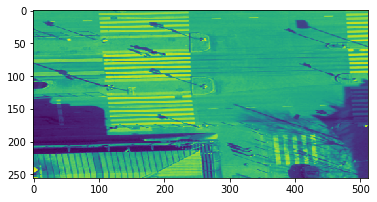

In [235]:
import matplotlib.pyplot as plt
plt.imshow(n_myimage)

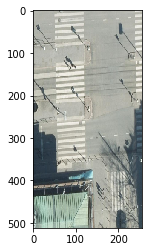

In [297]:

from PIL import Image  
im = Image.open(ci_paths[10])  
im1 = im.resize((256,512))
plt.imshow(im1)

In [238]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

In [312]:
fd, hog_image = hog(im1, orientations=9, pixels_per_cell=(16, 16),
cells_per_block=(2, 2), visualize=True, multichannel=True,block_norm="L1")

print('\n\nShape of Image Features\n\n')
print(fd.shape)
print(hog_image)



Shape of Image Features


(16740,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [282]:
15*31*81

37665

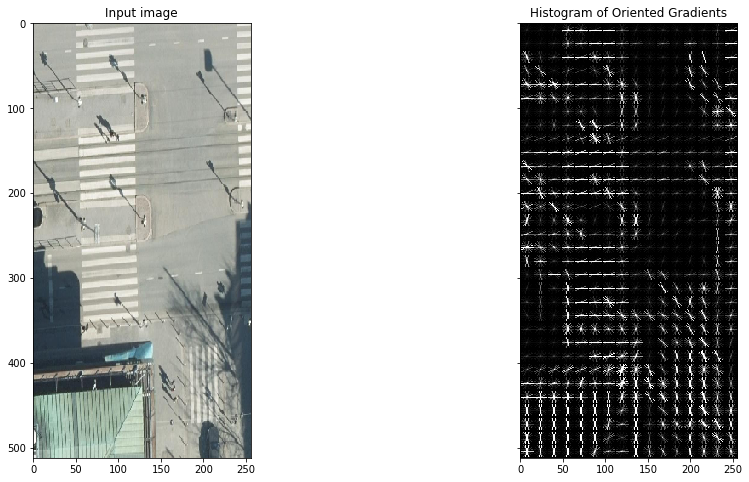

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(im1, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [16]:
hog_image_rescaled.shape

(512, 256)

# HOG Implementaion

In [17]:
hog_image_rescaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:

zc_images=[f for f in os.listdir("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/")]
non_zc_images=[f for f in os.listdir("C:/Users/35841/images/city_center_augumented_labelled/nozc_augumented/")]
all_images=zc_images+non_zc_images

In [22]:
len(zc_images)

600

In [23]:
len(non_zc_images)

912

In [32]:
label_list=[]
for item in all_images:
    label_list.append(item.split("__")[0])

new_df=pd.DataFrame(list(zip(all_images,label_list)),columns=["file_name","label"])

In [34]:
new_df.head()


,file_name,label
0,1__center_12__0.png,1
1,1__center_12__1.png,1
2,1__center_12__10.png,1
3,1__center_12__11.png,1
4,1__center_12__12.png,1


In [40]:
new_df["label"] = new_df["label"].astype(int)

In [42]:
new_df["bool_level"] = np.where(new_df["label"] > 0,1,0)

In [62]:
new_df.head(20)

,file_name,label,bool_level
0,1__center_12__0.png,1,1
1,1__center_12__1.png,1,1
2,1__center_12__10.png,1,1
3,1__center_12__11.png,1,1
4,1__center_12__12.png,1,1
5,1__center_12__13.png,1,1
6,1__center_12__14.png,1,1
7,1__center_12__15.png,1,1
8,1__center_12__16.png,1,1
9,1__center_12__17.png,1,1


In [64]:
 new_df.loc[0:605,"file_name"].tail(10)

596    7__center_54__271.png
597    7__center_54__272.png
598    7__center_54__273.png
599    7__center_54__274.png
600       0__center_0__0.png
601       0__center_0__1.png
602      0__center_0__10.png
603      0__center_0__11.png
604      0__center_0__12.png
605      0__center_0__13.png
Name: file_name, dtype: object

In [ ]:
from PIL import Image  


In [66]:
#dataset=np.ndarray(shape=(600,16740))
#i = 0
#for _file in new_df.loc[0:599,"file_name"]:
#    im = Image.open("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  
#    im1 = im.resize((256,512))
#    fd, hog_image = hog(im1, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), visualize=True, multichannel=True,block_norm="L1",feature_vector=True)
#
#    
#    #img = load_img("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  # this is a PIL image
#    #img.thumbnail(image_size)
#    # Convert to Numpy Array
#    #x = img_to_array(img)  
#    #x = x.reshape((3, 120, 160))
#    # Normalize
#    #x = (x - 128.0) / 128.0
#    dataset[i] = fd.reshape(1,-1)
#    i += 1

In [300]:
dataset=np.ndarray(shape=(len(all_images),16740))
i = 0
for _file in new_df.loc[0:599,"file_name"]:
    im = Image.open("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  
    im1 = im.resize((256,512))
    fd, hog_image = hog(im1, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), visualize=True, multichannel=True,block_norm="L1",feature_vector=True)

    
    #img = load_img("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  # this is a PIL image
    #img.thumbnail(image_size)
    # Convert to Numpy Array
    #x = img_to_array(img)  
    #x = x.reshape((3, 120, 160))
    # Normalize
    #x = (x - 128.0) / 128.0
    dataset[i] = fd.reshape(1,-1)
    i += 1
    
for _file in new_df.loc[600:,"file_name"]:
    im = Image.open("C:/Users/35841/images/city_center_augumented_labelled/nozc_augumented/"+ _file)  # this is a PIL image
    im1 = im.resize((256,512))
    fd, hog_image = hog(im1, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), visualize=True, multichannel=True,block_norm="L1")

    
    #img = load_img("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  # this is a PIL image
    #img.thumbnail(image_size)
    # Convert to Numpy Array
    #x = img_to_array(img)  
    #x = x.reshape((3, 120, 160))
    # Normalize
    #x = (x - 128.0) / 128.0
    dataset[i] = fd.reshape(1,-1)
    i += 1
    
   

In [301]:
dataset.shape

(1512, 4608)

In [242]:
len(new_df[new_df["label"]==7])

25

# Classification

### Support Vector Machine

In [307]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset,new_df.loc[:,"bool_level"], test_size=0.3,random_state=1)


In [308]:
from sklearn import svm
svc = svm.SVC(kernel="linear").fit(X_train, y_train)


In [309]:
y_pred=svc.predict(X_test)

In [310]:
from sklearn.metrics import confusion_matrix
con_mat=confusion_matrix(y_test,y_pred)
con_mat

array([[236,  34],
       [ 60, 124]], dtype=int64)

In [311]:
sum(np.diag(con_mat))/np.sum(con_mat)

0.7929515418502202

In [231]:
ind=[]
for i in range(len(y_pred)):
    if y_pred[i]!=y_test.values[i]:
        ind.append(y_test.index[i])

In [256]:
mis_classified=new_df.loc[ind]
a=mis_classified[mis_classified["label"]==7]
nind=a.index
a

,file_name,label,bool_level
579,7__center_54__254.png,7,1
598,7__center_54__273.png,7,1
596,7__center_54__271.png,7,1
593,7__center_54__268.png,7,1
575,7__center_54__250.png,7,1
584,7__center_54__259.png,7,1
581,7__center_54__256.png,7,1
599,7__center_54__274.png,7,1


'C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/4__center_9__597.png'

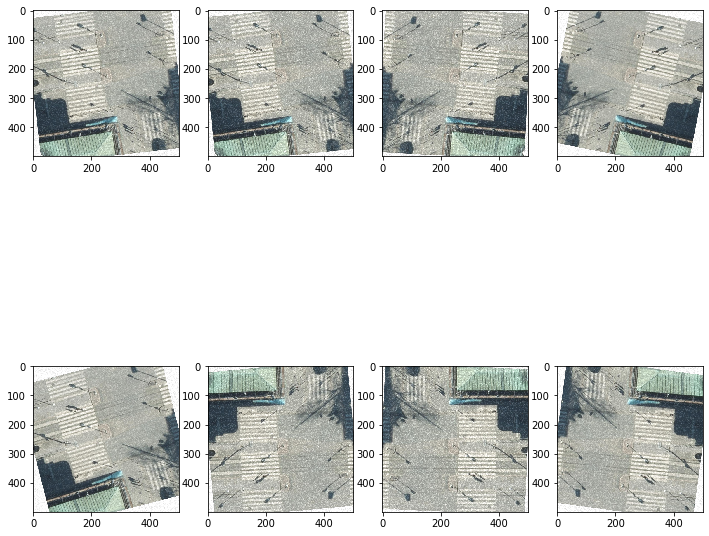

In [260]:
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12,12))
for i in range(1,9):
    img =Image.open("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+a.loc[nind[i-1],"file_name"])
    fig.add_subplot(2, 4, i)
    plt.imshow(img)
plt.show()

### Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)
y_pred=clf.predict(X_test)
clf.score(X_test,y_test)


C:\Users\35841\Anaconda3\envs\mllearn\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7995594713656388

### Random Forest Classifier

In [171]:
from sklearn.ensemble import RandomForestClassifier

In [172]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0).fit(X_train, y_train)


In [173]:
y_pred=clf.predict(X_test)
clf.score(X_test,y_test)

0.7004405286343612

# Regression

In [176]:

#Splitting 
X_train, X_test, y_train, y_test = train_test_split(dataset,new_df.loc[:,"label"], test_size=0.3)


## Support Vector Machine

In [177]:
from sklearn.svm import SVR
regressor = SVR(kernel='linear')



In [178]:
regressor.fit(X_train,y_train)
#5 Predicting a new result
y_pred = regressor.predict(X_test)


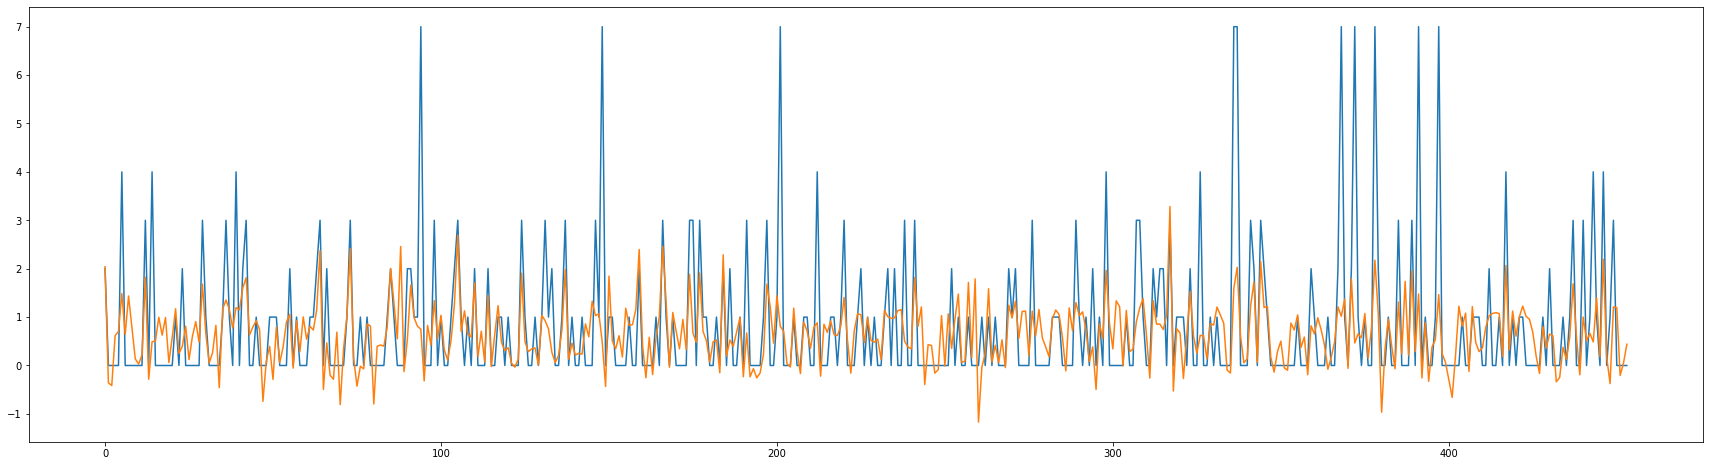

In [179]:
plt.figure(figsize=(30,8))
plt.plot(y_test.values)
plt.plot(y_pred)


In [79]:

(y_test)

107    1
160    1
58     1
118    1
443    3
      ..
518    3
339    2
349    2
215    1
45     1
Name: label, Length: 180, dtype: int32

In [131]:
from sklearn.metrics import r2_score
print(r2_score(y_test,y_pred))

0.2371689367538221


In [132]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

1.4001101024400586

In [133]:
## SVM with rbf kernel
regressor = SVR(gamma='scale', C=1.0, epsilon=0.2)
regressor.fit(X_train,y_train)
#5 Predicting a new result
y_pred = regressor.predict(X_test)


In [134]:
print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

0.14992056784443053
1.5602468989302587


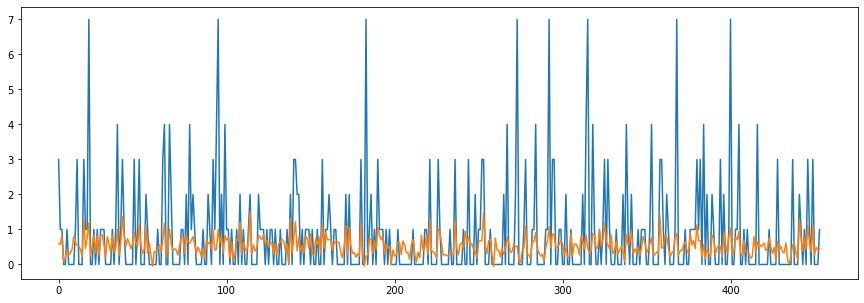

In [135]:
plt.figure(figsize=(15,5))
plt.plot(y_test.values)
plt.plot(y_pred)

## Random Forest

In [136]:
from sklearn.ensemble import RandomForestRegressor

In [137]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0,max_depth =10)
regressor.fit(X_train, y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [138]:
y_pred = regressor.predict(X_test)

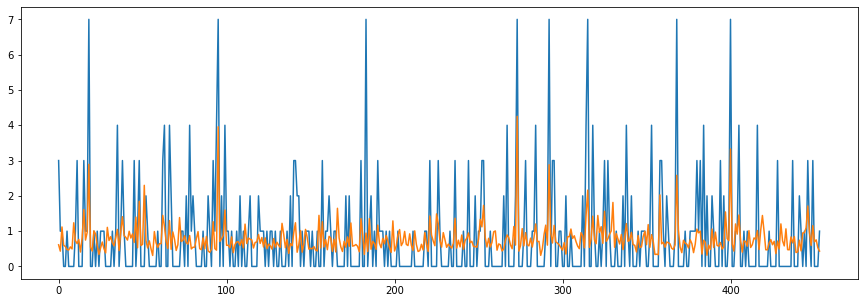

In [139]:
plt.figure(figsize=(15,5))
plt.plot(y_test.values)
plt.plot(y_pred)

In [140]:
print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

0.272589313960094
1.3350990792290982


## Linear Regression

In [141]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [142]:
y_pred=reg.predict(X_test)

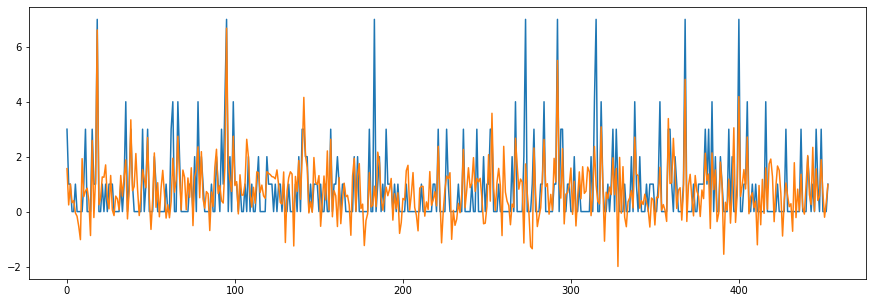

In [143]:
plt.figure(figsize=(15,5))
plt.plot(y_test.values)
plt.plot(y_pred)

In [144]:
print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

0.3450204958715778
1.202157941391329


In [107]:
print(y_pred[:10])
y_test.values[:10]

[0.64914133 1.43801601 0.77359127 2.30980025 2.00319566 1.00129139
 2.8522547  2.12976899 1.90643485 1.21038487]


array([1, 1, 1, 1, 3, 1, 3, 1, 1, 1])

In [145]:
from sklearn.linear_model import BayesianRidge
reg=BayesianRidge()
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)

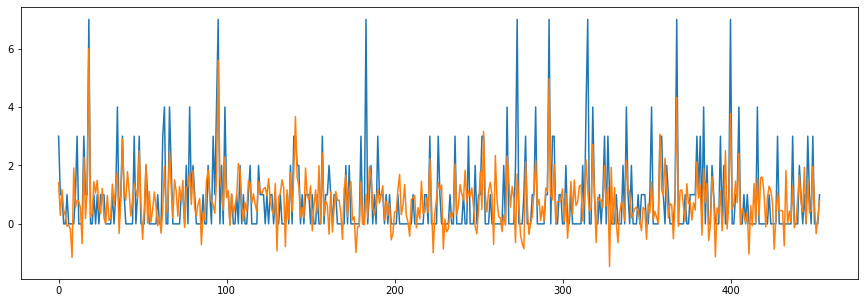

In [146]:
plt.figure(figsize=(15,5))
plt.plot(y_test.values)
plt.plot(y_pred)

In [147]:
print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

0.3907581314110644
1.1182104874058447


In [148]:

25*24

600

In [149]:
16*(81-24)

912

In [233]:
ci_paths


['C:/Users/35841/images/citycenterfocussed500by500/center_12.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_14.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_18.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_2.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_21.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_23.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_27.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_36.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_4.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_5.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_54.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_55.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_56.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_6.png',
 'C:/Users/35841/images/citycenterfocussed500by500/center_63.png',

# Local Binary Pattern Implementation


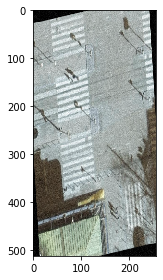

In [269]:
im=cv2.imread("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/7__center_54__254.png")
im1 = cv2.resize(im,(256,512))
im1.shape
imshow(im1)

In [272]:
from skimage.feature import local_binary_pattern
import cv2

lbp_dataset=np.ndarray(shape=(len(all_images),512*256))
i = 0
for _file in new_df.loc[0:599,"file_name"]:
    im = cv2.imread("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)
    #im = Image.open("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  
    im1 = cv2.resize(im,(256,512))
    image = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    #image=rgb2gray(im1)
    lbp_image=local_binary_pattern(image, P=8, R=10, method='default')
    
    
    #fd, hog_image = hog(im1, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), visualize=True, multichannel=True,block_norm="L1",feature_vector=True)

    
    #img = load_img("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  # this is a PIL image
    #img.thumbnail(image_size)
    # Convert to Numpy Array
    #x = img_to_array(img)  
    #x = x.reshape((3, 120, 160))
    # Normalize
    #x = (x - 128.0) / 128.0
    lbp_dataset[i] = lbp_image.reshape(-1,512*256)
    i += 1
    
for _file in new_df.loc[600:,"file_name"]:
    im = cv2.imread("C:/Users/35841/images/city_center_augumented_labelled/nozc_augumented/"+ _file)  # this is a PIL image
    im1 = cv2.resize(im,(256,512))
    image = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    #image=rgb2gray(im1)
    lbp_image=local_binary_pattern(image, P=8, R=10, method='default')
    
    
    #fd, hog_image = hog(im1, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), visualize=True, multichannel=True,block_norm="L1")

    
    #img = load_img("C:/Users/35841/images/city_center_augumented_labelled/zc_augumented/"+ _file)  # this is a PIL image
    #img.thumbnail(image_size)
    # Convert to Numpy Array
    #x = img_to_array(img)  
    #x = x.reshape((3, 120, 160))
    # Normalize
    #x = (x - 128.0) / 128.0
    lbp_dataset[i] = lbp_image.reshape(-1,512*256)
    i += 1
    
   

In [271]:
lbp_dataset.shape

(1512, 512, 256)

In [273]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lbp_dataset,new_df.loc[:,"bool_level"], test_size=0.3,random_state=1)


In [274]:
from sklearn import svm
svc = svm.SVC(kernel="linear").fit(X_train, y_train)


In [275]:
y_pred=svc.predict(X_test)

In [276]:
con_mat=confusion_matrix(y_test,y_pred)
con_mat

array([[251,  19],
       [ 84, 100]], dtype=int64)

In [279]:
svc.score(X_test,y_test)

0.7731277533039648